In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# nltk.download('omw-1.4')
from nltk import word_tokenize

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from collections import Counter

import emoji
from emot.emo_unicode import UNICODE_EMOJI,EMOTICONS_EMO,EMOJI_UNICODE

In [2]:
tweets = pd.read_csv("../data/cyberbullying_tweets.csv")

In [3]:
tweets.shape

(47692, 2)

In [4]:
tweets.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [5]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

<AxesSubplot:ylabel='cyberbullying_type'>

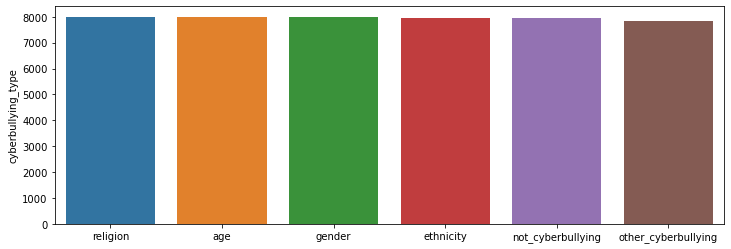

In [6]:
plt.figure(figsize=(12,4))
sns.barplot(x=tweets['cyberbullying_type'].value_counts().index, y=tweets['cyberbullying_type'].value_counts())

## Data preprocessing

### Extract hashtags, mentions, links and emojis

In [7]:
def extract_hashtags(self):
    regex = "#(\w+)"
    hashtag_list = re.findall(regex, self)
    l=[]
    for x in hashtag_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(hashtag_list) > 0:
        return ' '.join(hashtag_list)
    else:
        return ''

def extract_tags(self):
    regex = "@(\w+)"
    name_tag = re.findall(regex, self)
    l=[]
    for x in name_tag:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(l) > 0:
        return ' '.join(l)
    else:
        return ''

def extract_links(self):
    regex = r'(https?://\S+)'
    url_list = re.findall(regex, self)
    l=[]
    for x in url_list:
        x = x.lower()
        x = re.sub(r"[^a-zA-Z ]+", '', x)
        l.append(x)
    if len(url_list) > 0:
        return ' '.join(url_list)
    else:
        return ''

def extract_emojis(self):
    emoji_list = ''.join(c for c in self if c in emoji.UNICODE_EMOJI['en'])
    text_emoji =  ''.join(emoji.demojize(x) for x in emoji_list if x)
    regex = r"\:(.*?)\:"
    text_emoji =  re.findall(regex, text_emoji)
    if len(text_emoji) > 0:
        return ' '.join(text_emoji)
    else:
        return ''

In [8]:
tweets['tweet_text'] = tweets['tweet_text'].str.lower()
tweets['hash_tag']   = tweets['tweet_text'].apply(extract_hashtags)
tweets['name_tag']   = tweets['tweet_text'].apply(extract_tags)
tweets['url_tag']    = tweets['tweet_text'].apply(extract_links)
tweets['emoji_tag']  = tweets['tweet_text'].apply(extract_emojis)

In [9]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,"in other words #katandandre, your food was cra...",not_cyberbullying,katandandre mkr,,,
1,why is #aussietv so white? #mkr #theblock #ima...,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,@xochitlsuckkks a classy whore? or more red ve...,not_cyberbullying,,xochitlsuckkks,,
3,"@jason_gio meh. :p thanks for the heads up, b...",not_cyberbullying,,jasongio,,
4,@rudhoeenglish this is an isis account pretend...,not_cyberbullying,,rudhoeenglish,,


### Remove the symbols and numbers from tweet text

In [10]:
tweets['tweet_text'] = tweets['tweet_text'].apply(lambda x: re.sub(r"[^a-zA-Z ]+", '', x))

In [11]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,in other words katandandre your food was crapi...,not_cyberbullying,katandandre mkr,,,
1,why is aussietv so white mkr theblock imaceleb...,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,xochitlsuckkks a classy whore or more red velv...,not_cyberbullying,,xochitlsuckkks,,
3,jasongio meh p thanks for the heads up but no...,not_cyberbullying,,jasongio,,
4,rudhoeenglish this is an isis account pretendi...,not_cyberbullying,,rudhoeenglish,,


### Remove the hashtags, mentions, url and emojis from tweet text

In [12]:
def clean_text(text,dirt):
    dirt = dirt.split()
    for x in dirt:
        text = text.replace(x,'')
        text = " ".join(text.split())
    return text

In [13]:
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['name_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['hash_tag']),axis=1)
tweets['tweet_text'] = tweets.apply(lambda row :clean_text(row['tweet_text'],row['url_tag']),axis=1)

In [14]:
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,,,
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,,
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,,
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,,


### Process the tweets

In [15]:
def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('à', 'a')
    string = string.replace('â', 'a')

    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')

    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')
    
    return string

In [16]:
STOPWORDS = set(stopwords.words('english'))
lemma = WordNetLemmatizer()

In [17]:
def clean_tweet(text):
    # Remove Hashtag, Mention, https, www.asdfd, dsfadsf.com
    pattern = re.compile(r"(#[A-Za-z0-9]+|@[A-Za-z0-9]+|https?://\S+|www\.\S+|\S+\.[a-z]+|RT @)")
    text = pattern.sub('', str(text))
    text = " ".join(text.split())
    
    # Make all text lowercase
    text = text.lower()
    
    # Replace accented letters
    text = normalize_accent(text)

    # Lemmatize word and remove stopwords
    text = " ".join([lemma.lemmatize(word) for word in str(text).split() if word.isalpha() and word not in STOPWORDS])

    # Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    return text

In [18]:
tweets['clean_tweet'] = tweets['tweet_text']
tweets['clean_tweet'] = tweets['clean_tweet'].apply(lambda text: clean_tweet(text))
tweets.head()

,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag,clean_tweet
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,,,,word food crapilicious
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,,,,white studio
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,,,classy whore red velvet cupcake
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,,,meh p thanks head concerned another angry dude...
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,,,isi account pretending kurdish account like is...


In [19]:
tweets.isnull().sum()

tweet_text            0
cyberbullying_type    0
hash_tag              0
name_tag              0
url_tag               0
emoji_tag             0
clean_tweet           0
dtype: int64

In [20]:
tweets.to_csv("../data/cleaned_cyberbullying_tweets.csv", index=False)

## WordCloud

In [70]:
# for s in list(tweets.cyberbullying_type.value_counts().index):
#     plt.figure(figsize=(10,10))
#     wordcloud = WordCloud(min_font_size=5, max_words=1000, width=1600 , height=800 , stopwords=STOPWORDS).generate(str(tweets[tweets["cyberbullying_type"] == s].clean_tweet))
#     plt.axis('off')
#     plt.imshow(wordcloud)
#     plt.title(s)
#     plt.show()

## TFIDF

In [2]:
tweets = pd.read_csv("../data/cleaned_cyberbullying_tweets.csv")
tweets.hash_tag = tweets.hash_tag.fillna("")
tweets.emoji_tag = tweets.emoji_tag.fillna("")
tweets.clean_tweet = tweets.clean_tweet.fillna("")

In [3]:
tweets.shape

(47692, 7)

In [4]:
tweets.isna().sum()

tweet_text              134
cyberbullying_type        0
hash_tag                  0
name_tag              29599
url_tag               43391
emoji_tag                 0
clean_tweet               0
dtype: int64

In [5]:
print(tweets.shape)
tweets.head()

(47692, 7)


,tweet_text,cyberbullying_type,hash_tag,name_tag,url_tag,emoji_tag,clean_tweet
0,in other words your food was crapilicious,not_cyberbullying,katandandre mkr,NaN,NaN,,word food crapilicious
1,why is so white studio,not_cyberbullying,aussietv mkr theblock imacelebrityau today sun...,NaN,NaN,,white studio
2,a classy whore or more red velvet cupcakes,not_cyberbullying,,xochitlsuckkks,NaN,,classy whore red velvet cupcake
3,meh p thanks for the heads up but not too conc...,not_cyberbullying,,jasongio,NaN,,meh p thanks head concerned another angry dude...
4,this is an isis account pretending to be a kur...,not_cyberbullying,,rudhoeenglish,NaN,,isi account pretending kurdish account like is...


In [6]:
hshtg_vectorizer = TfidfVectorizer() #max_features=1000
hshtg_vec = hshtg_vectorizer.fit_transform(tweets.hash_tag)
print(hshtg_vec.shape)
# print(hshtg_vectorizer.get_feature_names())
tfidf_hashtags = hshtg_vectorizer.get_feature_names()

hshtg_tfidf = pd.DataFrame(hshtg_vec.todense(), columns=tfidf_hashtags)

(47692, 4555)


/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [7]:
emoji_vectorizer = TfidfVectorizer()
emoji_vec = emoji_vectorizer.fit_transform(tweets.emoji_tag)
print(emoji_vec.shape)
# print(emoji_vectorizer.get_feature_names())

tfidf_emojis = emoji_vectorizer.get_feature_names()

emoji_tfidf = pd.DataFrame(emoji_vec.todense(), columns=tfidf_emojis)

(47692, 174)


In [8]:
tfidf_vec = TfidfVectorizer(min_df=.0005, max_df=.90)
tfidf = tfidf_vec.fit_transform(tweets.clean_tweet)
print(tfidf.shape)
tfidf_tweet_terms = tfidf_vec.get_feature_names()

tweets_tfidf = pd.DataFrame(tfidf.todense(), columns=tfidf_tweet_terms)

(47692, 2791)


In [9]:
print(hshtg_tfidf.shape)
print(emoji_tfidf.shape)
print(tweets_tfidf.shape) # total 7810 columns

(47692, 4555)
(47692, 174)
(47692, 2791)


In [10]:
final_tweets = pd.concat([tweets[['tweet_text','cyberbullying_type']], tweets_tfidf, hshtg_tfidf, emoji_tfidf], axis=1)
print(final_tweets.shape)

(47692, 7522)


In [11]:
final_tweets = final_tweets.loc[:,~final_tweets.columns.duplicated()]
print(final_tweets.shape)

(47692, 7007)


## Feature Importance

In [12]:
X = final_tweets.drop(['tweet_text','cyberbullying_type'], axis=1)
Y = final_tweets.cyberbullying_type

In [16]:
def decisionTreeFeatImp(X_train, y_train):
    grid_params = {'max_depth' : [int(x) for x in np.linspace(190, 220, num = 20)],#[85, 87, 89, 90, 91, 93],
                   'criterion' : ['entropy', 'gini'], 
                   'splitter' : ['best', 'random'] }
    
        
    dt_clf = DecisionTreeClassifier()
    dt_cv = GridSearchCV(estimator = dt_clf, 
                                   param_grid = grid_params, 
                                   cv = 7, 
                                   verbose=2, 
                                   n_jobs = -1, 
                                   scoring = 'f1_weighted')
    
    dt_cv.fit(X_train, y_train.values.ravel())
    dt_best = dt_cv.best_estimator_
    print("dt_cv.best_params_", dt_cv.best_params_)
    y_predicted = dt_best.predict(X_train)
    dt_accuracy = accuracy_score(y_train, y_predicted)
    dt_f1 = f1_score(y_train, y_predicted, average="weighted")
    
    print("In sample accurancy = ", dt_accuracy)
    print("In sample f1 = ", dt_f1)
    print('Best Params = ', dt_cv.best_params_)
    
    feat_imp = dt_best.feature_importances_
    return feat_imp


# # define the model
# model = DecisionTreeClassifier()
# # fit the model
# model.fit(X, Y)
# # get importance
# imp_features = model.feature_importances_

In [19]:
%%time
feat_imp = decisionTreeFeatImp(X,Y)

Fitting 7 folds for each of 80 candidates, totalling 560 fits
dt_cv.best_params_ {'criterion': 'gini', 'max_depth': 215, 'splitter': 'random'}
In sample accurancy =  0.9231736978948252
In sample f1 =  0.9237135896095231
Best Params =  {'criterion': 'gini', 'max_depth': 215, 'splitter': 'random'}
CPU times: user 26.6 s, sys: 5.05 s, total: 31.6 s
Wall time: 52min 4s


In [26]:
feat_imp_index = feat_imp.argsort()[::-1]

In [54]:
imp_cols = list(X.columns[feat_imp_index[:1757]])

In [57]:
len(imp_cols)

1757

We extract only the necessary columns to a new dataframe that will be used henceforth

In [58]:
X_mod = X[imp_cols]

In [65]:
df_for_models = pd.concat([X_mod, Y],axis=1)

In [71]:
df_for_models.to_csv("../data/df_for_models.csv", index=False)

# Model training

## Multi-class dataset

In [2]:
df = pd.read_csv("../data/df_for_models.csv")

In [3]:
X = df.drop(['cyberbullying_type'], axis=1)
Y = df.cyberbullying_type

In [4]:
print(X.shape)
print(Y.shape)

(47692, 1757)
(47692,)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

## Binary class dataset

In [6]:
binary_df = pd.read_csv("../data/df_for_models.csv")
binary_df["cyberbullying_type"] = binary_df["cyberbullying_type"].apply(lambda x: "not_cyberbullying" if x == "not_cyberbullying" else "cyberbullying")
binary_df["cyberbullying_type"].value_counts()

cyberbullying        39747
not_cyberbullying     7945
Name: cyberbullying_type, dtype: int64

In [7]:
X_bin = binary_df.drop(['cyberbullying_type'], axis=1)
Y_bin = binary_df.cyberbullying_type

In [8]:
X_bin_train, X_bin_test, y_bin_train, y_bin_test = train_test_split(X_bin, Y_bin, test_size=0.3, random_state=42)

## Decision Tree

In [19]:
def decisionTreeClassifier(X_train, X_test, y_train, y_test):
    grid_params = {'max_depth' : [int(x) for x in np.linspace(180, 200, num = 20)],
                   'criterion' : ['entropy', 'gini'], 
                   'splitter' : ['best', 'random'] }
    
        
    dt_clf = DecisionTreeClassifier()
    dt_cv = GridSearchCV(estimator = dt_clf, 
                                   param_grid = grid_params, 
                                   cv = 7, 
                                   verbose=2, 
                                   n_jobs = -1, 
                                   scoring = 'f1_weighted')
    
    dt_cv.fit(X_train, y_train.values.ravel())
    print("dt_cv.best_params_", dt_cv.best_params_)
    
    dt_best = dt_cv.best_estimator_
    y_predicted = dt_best.predict(X_test)
    dt_accuracy = accuracy_score(y_test, y_predicted)
    dt_f1 = f1_score(y_test, y_predicted, average="weighted")
    
    print("dt_accuracy, dt_f1", dt_accuracy, dt_f1)
    
    return dt_accuracy, dt_f1

In [87]:
%%time
a,f = decisionTreeClassifier(X_train, X_test, y_train, y_test)
print("a =", a)
print("f =", f)

Fitting 7 folds for each of 80 candidates, totalling 560 fits
dt_cv.best_params_ {'criterion': 'gini', 'max_depth': 189, 'splitter': 'random'}
dt_accuracy, dt_f1 0.800461280402572 0.7996694355636723
a = 0.800461280402572
f = 0.7996694355636723
CPU times: user 8.74 s, sys: 637 ms, total: 9.38 s
Wall time: 14min 3s


In [20]:
%%time
a_bin,f_bin = decisionTreeClassifier(X_bin_train, X_bin_test, y_bin_train, y_bin_test)
print("a_bin =", a_bin)
print("f_bin =", f_bin)

Fitting 7 folds for each of 80 candidates, totalling 560 fits
dt_cv.best_params_ {'criterion': 'entropy', 'max_depth': 190, 'splitter': 'random'}
dt_accuracy, dt_f1 0.8541375454291306 0.8384417124230957
a_bin = 0.8541375454291306
f_bin = 0.8384417124230957
CPU times: user 8.24 s, sys: 779 ms, total: 9.02 s
Wall time: 14min 58s
[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  14.6s
[CV] END ....criterion=entropy, max_depth=181, splitter=best; total time=  12.8s
[CV] END ..criterion=entropy, max_depth=181, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  13.3s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=183, splitter=best; total time=  13.7s
[CV] END ..criterion=entropy, max_depth=183, splitter=random; total time=  11.0s
[CV] END ....criterion=entropy, max_depth=184, splitter=best; total time=  13.9s
[CV] END ....criterion=

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  14.6s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=181, splitter=best; total time=  12.5s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  13.4s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.9s
[CV] END ....criterion=entropy, max_depth=183, splitter=best; total time=  14.0s
[CV] END ..criterion=entropy, max_depth=183, splitter=random; total time=  11.2s
[CV] END ..criterion=entropy, max_depth=184, splitter=random; total time=  11.4s
[CV] END ..criterion=entropy, max_depth=184, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.5s
[CV] END ....criterion=entropy, max_depth=186, splitter=best; total time=  14.7s
[CV] END ..criterion=entropy, max_depth=186, splitter=random; total time=  11.2s
[CV] END ....criterion=entro

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  14.8s
[CV] END ....criterion=entropy, max_depth=181, splitter=best; total time=  12.3s
[CV] END ..criterion=entropy, max_depth=181, splitter=random; total time=  10.5s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=183, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=183, splitter=random; total time=  11.0s
[CV] END ....criterion=entropy, max_depth=184, splitter=best; total time=  13.6s
[CV] END ..criterion=entropy, max_depth=184, splitter=random; total time=  10.1s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.4s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.7s
[CV] END ..criterion=entropy, max_depth=186, splitter=random; total time=  12.2s
[CV] END ..criterion=entropy

[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.9s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.1s
[CV] END ....criterion=entropy, max_depth=181, splitter=best; total time=  12.3s
[CV] END ..criterion=entropy, max_depth=181, splitter=random; total time=  10.9s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.3s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.8s
[CV] END ....criterion=entropy, max_depth=183, splitter=best; total time=  13.7s
[CV] END ....criterion=entropy, max_depth=184, splitter=best; total time=  13.3s
[CV] END ..criterion=entropy, max_depth=184, splitter=random; total time=  10.9s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.3s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=   9.8s
[CV] END ....criterion=entropy, max_depth=186, splitter=best; total time=  15.7s
[CV] END ....criterion=entro

## Random Forest

### Base model

In [88]:
rf_clf = RandomForestClassifier(n_estimators= 200)
cross_val_score(rf_clf, X_train,y_train.values.ravel(), cv=5, scoring = 'accuracy')

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.8s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.1s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  12.3s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.5s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  12.5s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=195, splitter=random; total time=  10.4s
[CV] END ....criterion=entro

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.6s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.6s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  11.7s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.4s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  11.8s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.4s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  11.8s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.3s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=   9.6s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=   9.8s
[CV] END ..criterion=entropy, max_depth=195, splitter=random; total time=  10.7s
[CV] END ....criterion=entro

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.4s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=   9.8s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=   9.8s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=   9.8s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=   9.7s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.0s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  12.1s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=  10.5s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  11.9s
[CV] END ..criterion=entropy

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  14.1s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.6s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  11.9s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.6s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  12.2s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=195, splitter=random; total time=  10.8s
[CV] END ....criterion=entro

[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  11.0s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=   9.4s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  11.8s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=   9.7s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  12.1s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  11.8s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.0s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  11.9s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.6s
[CV] END ..criterion=entropy

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.8s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.6s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=   9.7s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=   9.6s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.4s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  11.6s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.2s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  11.8s
[CV] END ..criterion=entropy, max_depth=193, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.2s
[CV] END ....criterion=entro

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.9s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=  10.5s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=185, splitter=random; total time=  10.7s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.6s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.2s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.4s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  12.3s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.2s
[CV] END ..criterion=entropy, max_depth=195, splitter=random; total time=  10.7s
[CV] END ....criterion=entro

[CV] END ....criterion=entropy, max_depth=180, splitter=best; total time=  13.5s
[CV] END ..criterion=entropy, max_depth=180, splitter=random; total time=  10.5s
[CV] END ....criterion=entropy, max_depth=182, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=182, splitter=random; total time=   9.5s
[CV] END ....criterion=entropy, max_depth=185, splitter=best; total time=  12.2s
[CV] END ....criterion=entropy, max_depth=187, splitter=best; total time=  11.9s
[CV] END ..criterion=entropy, max_depth=187, splitter=random; total time=  10.3s
[CV] END ....criterion=entropy, max_depth=190, splitter=best; total time=  11.9s
[CV] END ..criterion=entropy, max_depth=190, splitter=random; total time=  10.1s
[CV] END ....criterion=entropy, max_depth=193, splitter=best; total time=  12.5s
[CV] END ....criterion=entropy, max_depth=195, splitter=best; total time=  12.0s
[CV] END ..criterion=entropy, max_depth=195, splitter=random; total time=  10.3s
[CV] END ....criterion=entro

array([0.8196795 , 0.81473716, 0.81353901, 0.81908043, 0.81545836])

### Grid Search

In [25]:
def randomForestClassifier(X_train, X_test, y_train, y_test):

    grid_params = {'n_estimators': [50, 60, 70, 80],
                   'max_depth': [230, 240, 250, 260],
                   'min_samples_split': [20, 30, 40],
                   'min_samples_leaf': [1, 2, 3]}

    rf_clf = RandomForestClassifier()

    rf_cv = GridSearchCV(estimator = rf_clf, 
                         param_grid=grid_params, 
                         cv =5, 
                         verbose=1, 
                         scoring = 'f1_weighted', 
                         n_jobs=-1)
    
    rf_cv.fit(X_train, y_train.values.ravel())
    print("rf_cv.best_params_", rf_cv.best_params_)
    
    rf_best = rf_cv.best_estimator_
    y_predicted = rf_best.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_predicted)
    rf_f1 = f1_score(y_test, y_predicted, average="weighted")
    print("rf_accuracy, rf_f1", rf_accuracy, rf_f1)

    return rf_accuracy, rf_f1

In [10]:
%%time
a,f = randomForestClassifier(X_train, X_test, y_train, y_test)
print("a =", a)
print("f =", f)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
rf_cv.best_params_ {'max_depth': 200, 'min_samples_leaf': 2, 'min_samples_split': 39, 'n_estimators': 102}
rf_accuracy, rf_f1 0.8285574503774112 0.8269197487384217
a = 0.8285574503774112
f = 0.8269197487384217
CPU times: user 21.9 s, sys: 514 ms, total: 22.4 s
Wall time: 21min 53s


In [26]:
%%time
a_bin,f_bin = randomForestClassifier(X_bin_train, X_bin_test, y_bin_train, y_bin_test)
print("a_bin =", a_bin)
print("f_bin =", f_bin)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
rf_cv.best_params_ {'max_depth': 240, 'min_samples_leaf': 2, 'min_samples_split': 20, 'n_estimators': 50}
rf_accuracy, rf_f1 0.8698630136986302 0.8533290537192774
a_bin = 0.8698630136986302
f_bin = 0.8533290537192774
CPU times: user 14.7 s, sys: 930 ms, total: 15.6 s
Wall time: 37min 29s


## XG Boost

In [9]:
def xGboostClassifier(X_train, X_test, y_train, y_test):
    
    grid_params = {"n_estimators" : [int(x) for x in np.linspace(50, 500, num = 20)],
        "learning_rate" : [ 0.15, 0.20, 0.25, 0.30 ] ,
        "max_depth" : [int(x) for x in np.linspace(100, 250, num = 20)],
        "min_child_weight" : [ 1, 3, 5, 7 ],
        "gamma" : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
        "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

    xgb_clf = XGBClassifier()

    xgb_cv = RandomizedSearchCV(estimator = xgb_clf, 
                                    param_distributions = grid_params,  
                                    n_iter=50,
                                    cv=2,
                                    random_state=42, 
                                    n_jobs = -1, 
                                    scoring = 'f1_weighted')
    xgb_cv.fit(X_train, y_train.values.ravel())
    print("xgb_cv.best_params_", xgb_cv.best_params_)
    
    xgb_best = xgb_cv.best_estimator_

    y_predicted = xgb_best.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, y_predicted)
    xgb_f1 = f1_score(y_test, y_predicted, average="weighted")
    print("xgb_accuracy, xgb_f1", xgb_accuracy, xgb_f1)

    return xgb_accuracy, xgb_f1

In [10]:
%%time
a,f = xGboostClassifier(X_train, X_test, y_train, y_test)
print("a =", a)
print("f =", f)

# xgb_cv.best_params_ {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 100, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.5}
# xgb_accuracy, xgb_f1 0.8151383841207716 0.8179419349994229
# a = 0.8151383841207716
# f = 0.8179419349994229
# CPU times: user 1h 24min 11s, sys: 1min 36s, total: 1h 25min 47s
# Wall time: 1d 16h 20min 19s

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:59:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[19:20:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:42:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:31:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:59:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:39:17] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:26:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:23:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:59:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:37:26] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:23:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[06:12:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:58:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:19] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:50:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:15:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:58:38] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:27] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:09:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:27:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[08:07:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:15:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:57:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[15:58:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:22:32] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:12:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:32:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

xgb_cv.best_params_ {'n_estimators': 50, 'min_child_weight': 3, 'max_depth': 100, 'learning_rate': 0.15, 'gamma': 0.2, 'colsample_bytree': 0.5}
xgb_accuracy, xgb_f1 0.8151383841207716 0.8179419349994229
a = 0.8151383841207716
f = 0.8179419349994229
CPU times: user 1h 24min 11s, sys: 1min 36s, total: 1h 25min 47s
Wall time: 1d 16h 20min 19s


In [29]:
%%time
a_bin,f_bin = xGboostClassifier(X_bin_train, X_bin_test, y_bin_train, y_bin_test)
print("a_bin =", a_bin)
print("f_bin =", f_bin)

[00:34:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:45:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:54:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[04:29:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:20:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:17:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:17:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:58:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:59] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:42:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:50:14] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:59:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:39:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:50] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:13:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:21:31] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:38:20] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:49] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[01:18:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:14:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:55:47] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

[00:34:44] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:38:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:11:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:19:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/homeb

xgb_cv.best_params_ {'n_estimators': 144, 'min_child_weight': 1, 'max_depth': 250, 'learning_rate': 0.25, 'gamma': 0.4, 'colsample_bytree': 0.7}
xgb_accuracy, xgb_f1 0.8470785574503774 0.8397420989282475
a_bin = 0.8470785574503774
f_bin = 0.8397420989282475
CPU times: user 2h 35min 24s, sys: 2min 9s, total: 2h 37min 33s
Wall time: 9h 25min 3s


In [ ]:
# just 25 fits
# xgb_cv.best_params_ {'n_estimators': 192, 'min_child_weight': 1, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0.4, 'colsample_bytree': 0.5}
# a = 0.7813111545988258
# f = 0.7832539672082043
# CPU times: user 1min 54s, sys: 12.1 s, total: 2min 6s
# Wall time: 8min 6s

In [8]:
def xGboost(X_train, X_test, y_train, y_test):

    xgb_clf = XGBClassifier(n_estimators=200, max_depth=150)

    print("Fitting the model")
    xgb_clf.fit(X_train, y_train.values.ravel())
    
    y_predicted = xgb_clf.predict(X_test)
    xgb_accuracy = accuracy_score(y_test, y_predicted)
    xgb_f1 = f1_score(y_test, y_predicted, average="weighted")

    return xgb_accuracy, xgb_f1

In [9]:
%%time
a,f = xGboost(X_train, X_test, y_train, y_test)
print("a =", a)
print("f =", f)

# xgb_clf = XGBClassifier(n_estimators=150, max_depth=140)
# a = 0.8029074643556052
# f = 0.8059889605535215
# CPU times: user 6h 16min 2s, sys: 6min 14s, total: 6h 22min 17s
# Wall time: 50min 18s

Fitting the model


/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:18:45] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
a = 0.8096169974839251
f = 0.8126723079283034
CPU times: user 12h 28min 54s, sys: 10min 54s, total: 12h 39min 48s
Wall time: 1h 36min 38s


## Bagging

In [27]:
def baggingClassifier(X_train, X_test, y_train, y_test):
    
    base_estimators = [DecisionTreeClassifier(criterion="entropy", max_depth = 8),
                       MultinomialNB(),
                       LogisticRegression(solver='saga', n_jobs=-1,penalty='l2')]
    
    random_grid = {'base_estimator':base_estimators,
                   'n_estimators': [20, 40, 60, 80, 100, 120],
                   'max_samples': [1, 2, 5, 10, 25],
                   'max_features': [1, 2, 4, 8, 16],
                   'bootstrap': [True, False]}

    bag = BaggingClassifier()
    bag_cv = GridSearchCV(estimator = bag, 
                                    param_grid = random_grid,
                                    cv = 10, 
                                    verbose = 2, 
                                    n_jobs=-1, 
                                    scoring = 'f1_weighted')
    
    bag_cv.fit(X_train, y_train.values.ravel())
    print("bag_cv.best_params_", bag_cv.best_params_)
    
    best_classifier = bag_cv.best_estimator_

    y_predicted = best_classifier.predict(X_test)
    bag_accuracy = accuracy_score(y_test, y_predicted)
    bag_f1 = f1_score(y_test, y_predicted, average="weighted")
    print("bag_accuracy, bag_f1", bag_accuracy, bag_f1)

    return bag_accuracy, bag_f1

In [28]:
%%time
a,f = baggingClassifier(X_train, X_test, y_train, y_test)
print("a =", a)
print("f =", f)

Fitting 10 folds for each of 900 candidates, totalling 9000 fits

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   7.1s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=80; total time=   0.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=  13.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samp

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=SVC(gamma='auto'), bootstrap=True, max_features=2, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=SVC(gamma='auto'), bootstrap=True, max_features=2, max_samples=10, n_estimators=60; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=5, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), b

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   3.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   5.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=  12.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_de

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=40; total time=   0.7s
[CV] END base_estimator=SVC(gamma='auto'), bootstrap=True, max_features=2, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=SVC(gamma='auto'), bootstrap=True, max_features=2, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeC

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=10, n_estimators=100; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   4.1s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimator

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=10, n_estimators=100; total time=   3.3s
[CV] END base_estimator=SVC(gamma='auto'), bootstrap=True, max_features=2, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END bas

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=1, n_estimators=120; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=80; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   2.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.6s
[CV] END base_estimator=Mu

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=   1.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=MultinomialNB(

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=   1.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=80; total time=   1.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   4.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=   1.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bo

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=20; total time=   3.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=20; total time=   4.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=10, n_estimators=100; total time=   2.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=10, n_es

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=10, n_estimators=100; total time=   2.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=  

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=   4.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True,

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=60; total time=   0.5s
[CV]

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   0.4s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=120; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.4s
[CV]

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=1, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   0.5s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END 

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=40; total time=   0.4s
[CV] EN

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END 

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=60; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=2, max_samples=2, n_estimators=120; total time=   0.6s
[CV] END

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=20; total time=   0.4s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   0.7s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.3s
[CV] EN

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=5, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV]

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=4, max_samples=10, n_estimators=80; total time=   0.6s
[CV]

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   0.3s
[CV] E

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=10, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   0.7s
[

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=5, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   0.6s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[CV]

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=8, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=1, n_estimators=40; total time=   0.5s
[

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=80; total time=   0.8s

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=1, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   0.4s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   0.4s


[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=60; total time=   0.5

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.3s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.4s


[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=1, max_samples=2, n_estimators=120; total time=   0.6s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=1, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=1, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=1, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=20; total time=   0.3s
[

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   0.6s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=20; total time=   0.3s


[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=2, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=20; total time=   0.3s
[

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   0.6s
[C

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=120; total time=   0.7s

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=80; total time=   0.6

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=5, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=2, max_samples=10, n_estimators=60; total time=   0.5

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   0.7s
[

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=10, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.5

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   0

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total time=   0.3s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=120; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=1, n_estimators=20; total time=   0.

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=4, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=1, n_estimators=20; total time=   0

[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   0.

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=1, n_estimators=100; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=40; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeCl

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=80; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeCl

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=80; total time=   0.8s
[CV] END base_estimator=DecisionTreeCla

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeCla

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=100; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=DecisionTreeCl

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=1, n_estimators=120; total time=   1.0s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=40; total time=   0.5s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=60; total time=   0.7s
[CV] END base_estimator=DecisionTreeCl


[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=60; total time=   0.6s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=80; total time=   0.7s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=80; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=100; total time=   0.8s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=2, n_estimators=120; total time=   0.9s
[CV] END base_estimator=DecisionTreeClassifier(criterion='entropy', max_depth=8), bootstrap=False, max_features=16, max_samples=5, n_estimators=20; total time=   

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV]

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=100; total time=   1.0s
[CV] 

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   0.6s

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=5, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=40; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   0.9s


[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   1.1s[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   0.6

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=1, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.4s

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   0.7s
[C

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   1.3s
[CV]

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=2, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.9s
[

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.9s
[CV] E

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=100; total time=   1.1s
[CV] 

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=120; total time=   1.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=5, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=60; total time=   0.7s
[

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=4, max_samples=10, n_estimators=120; total time=   1.

[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=   1.3

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=100; total time=   1.

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=8, max_samples=25, n_estimators=120; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=40; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=40; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=80; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=100; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=1, n_estimators=120; total time=   1.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=40; total time=   0.

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=100; total time=   1.3

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=100; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=   1.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=100; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=120; total time=   1.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=True, max_features=16, max_samples=5, n_estimators=120; total time=   

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=2, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=80; total time=   0.9

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=5, n_estimators=120; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=60; total time= 

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=40; total tim

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=40; total time= 

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=80; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=100; total time=   1

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=1, max_samples=25, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=80; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=120; total time=   

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=1, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=2, max_samples=2, n_estimators=120; total time=   

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=1, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=40; total time=   0.6

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=10, n_estimators=120; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=2, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=60; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=5, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=100; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total ti

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total ti

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=80; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=40; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=100; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=10, n_estimators=120; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=4, max_samples=25, n_estimators=20; total tim

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=120; total time=   1.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=100; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=1, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   0

[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=40; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=60; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=80; total time=   1.0s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   1.2s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=20; total ti

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=60; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=100; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1,

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=40; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=8, max_samples=25, n_estimators=120; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1,

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=120; total time=   2.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=100; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=120; total time=   1.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=1, n_estimators=120; total time=   1.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=2,

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   1.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=100; total time=   1.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=120; total time=   1.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=10, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_sampl

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=120; total time=   2.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=20; total time=   0.5s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=40; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=40; total time=   0.8s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=5,

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.6s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=20; total time=   0.4s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=40; total time=   0.7s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=60; total time=   0.9s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=80; total time=   1.1s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_samples=25, n_estimators=100; total time=   1.3s
[CV] END base_estimator=MultinomialNB(), bootstrap=False, max_features=16, max_sampl

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=2, n_estimators=80; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=80; total time=   1.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=80; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=100; total time=   2.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=120; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=25, n_estimators=100; total time=   3.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=5, n_estimators=120; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=40; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   1.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   2.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boot

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   1.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=60; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   2.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   2.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=60; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=100; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootst

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   3.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=60; total time=   1.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=80; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=Tr

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   0.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=100; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=10, n_estimators=120; total time=   3.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=1, max_samples=25, n_estimators=40; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=40; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=1, n_estimators=40; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=Tr

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   4.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=2, n_estimators=100; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=2, n_estimators=100; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=2, n_estimators=120; total time=   4.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=5, n_estimators=60; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=5, n_estimators=60; total time=   1.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstra

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=2, max_samples=25, n_estimators=120; total time=   4.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=40; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=60; total time=   4.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   3.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   3.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=20; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=40; total time=   1.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=20; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   3.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   2.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=T

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   4.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=60; total time=   1.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=80; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=100; total time=   5.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=1, n_estimators=120; total time=   3.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=120; total time=   7.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   3.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   5.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=40; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=60; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=5, n_estimators=80; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=60; total time=   2.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=80; total time=   3.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=100; total time=   4.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=2, n_estimators=120; total time=   4.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   9.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=25, n_estimators=40; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=25, n_estimators=60; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=25, n_estimators=80; total time=   4.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=25, n_estimators=80; total time=   4.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=4, max_samples=25, n_estimators=100; total time=   5.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=40; total time=   4.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=2, n_estimators=120; total time=   5.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=20; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=20; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=40; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=60; total time=   4.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   5.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   6.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   6.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=  12.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=  10.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=5, n_estimators=120; total time=   8.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   4.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   4.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   7.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   8.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   8.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=60; total time=  13.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=20; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=40; total time=   4.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   5.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=60; total time=   5.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=80; total time=   6.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=120; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=100; total time=   9.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=10, n_estimators=120; total time=  11.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=25, n_estimators=20; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   4.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=8, max_samples=25, n_estimators=40; total time=   4.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=60; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=60; total time=  10.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=80; total time=   7.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=80; total time=  11.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=100; total time=  14.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=2, n_estimators=120; total time=  13.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boot

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=60; total time=  13.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=60; total time=  15.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=80; total time=  17.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=100; total time=  21.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=  27.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga')

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=100; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=120; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=40; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boot

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootst

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=2, n_estimators=80; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=1, n_estimators=120; total time=   2.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=40; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=60; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=80; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=100; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boot

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=True, max_features=16, max_samples=25, n_estimators=120; total time=  27.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=40; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=60; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=2, n_estimators=80; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=10, n_estimators=60; total time=   1.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=10, n_estimators=80; total time=   1.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=10, n_estimators=100; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=10, n_estimators=120; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=10, n_estimators=120; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=1, max_samples=25, n_estimators=40; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=2, n_estimators=100; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=2, n_estimators=120; total time=   3.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   1.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   1.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=40; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   2.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   1.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=80; total time=   2.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   2.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=120; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=60; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=80; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=80; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=100; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=5, n_estimators=120; total time=   3.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=10, n_estimators=20; total time=   0.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bo

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=1, n_estimators=100; total time=  12.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=10, n_estimators=80; total time=   2.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=10, n_estimators=100; total time=   3.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=10, n_estimators=120; total time=   3.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=20; total time=   1.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=40; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga')

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=1, n_estimators=100; total time=   4.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=10, n_estimators=120; total time=   3.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=20; total time=   0.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=20; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=40; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=2, max_samples=25, n_estimators=60; total time=   2.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'),

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=1, n_estimators=120; total time=  11.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=1, n_estimators=60; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=1, n_estimators=80; total time=   2.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=1, n_estimators=100; total time=   3.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=1, n_estimators=100; total time=   3.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=1, n_estimators=120; total time=   4.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bo

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=40; total time=   2.7sbag_cv.best_params_ {'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=8), 'bootstrap': True, 'max_features': 16, 'max_samples': 25, 'n_estimators': 100}
bag_accuracy, bag_f1 0.4695974280123008 0.44616447726027625
a = 0.4695974280123008
f = 0.44616447726027625
CPU times: user 35.9 s, sys: 5.78 s, total: 41.6 s
Wall time: 40min 8s

[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   2.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   2.8s
[CV] END base_estimator=Log

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   0.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   1.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=60; total time=   3.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=60; total time=   4.0s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=1, n_estimators=100; total time=   4.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=1, n_estimators=120; total time=   9.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   0.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   2.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   3.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   4.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   3.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total time=   5.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=120; total time=   5.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=20; total time=   1.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=40; total time=   1.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=40; total time=   1.5s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=60; total time=   1.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=60; total time=   1.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=5, n_estimators=80; total time=   2.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=60; total time=   3.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=60; total time=   4.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=80; total time=   4.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=100; total time=   8.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=5, n_estimators=120; total time=   8.9s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=10, n_estimators=20; total time=   2.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bo

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   0.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   1.6s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=20; total time=   0.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   1.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=40; total time=   3.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=8, max_samples=2, n_estimators=60; total time=   3.8s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), boots

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver


[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   2.4s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=40; total time=   2.3s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=60; total time=   2.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=80; total time=   4.2s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total time=   4.7s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'), bootstrap=False, max_features=4, max_samples=25, n_estimators=100; total time=   5.1s
[CV] END base_estimator=LogisticRegression(n_jobs=-1, solver='saga'

/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ensemble_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:352: Conver